 # Feature Extraction
 ## Imports
 General stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
import os
import pathlib

# Audio processing/tools import
import librosa
import librosa.display
from scipy.io.wavfile import read 
from IPython.display import Audio
# REMEMBER you need ffmpeg installed

# Parellization libraries
from joblib import Parallel, delayed

# Import custom module containing useful functions
import sonicboom

# Import helper functions
import time


 ## Define some constants

In [2]:
SAVEPATH = './output/intermediate-data/'
#FILEDESC = 'filedata-librosaFeatures.pkl'
FILEDESC = 'filedata-librosaConventionalFeatures.pkl'


 ## Read and add filepaths to original UrbanSound metadata

In [3]:
filedata = sonicboom.init_data('./data/UrbanSound8K/')

# NOTE Remember to delete troublesome wav file: \fold1\88466-7-0-0.wav


Calling 'init_data'
Finished 'init_data' in 0.9698 secs


 ## Sample down

In [4]:
sampleDown = True

# samples down grouping by class - this gives me X items from each class.
# as_index=False is important because otherwise,
# Pandas calls the index and the column the same thing, confusing itself
if (sampleDown == True):
    filedata = filedata.groupby(
        'class', 
        as_index=False, 
        group_keys=False
    ).apply(lambda x: x.sample(n=25, random_state=0))

# check that the sample down is working
# as_index=False is important because otherwise,
# Pandas calls the index and the column the same thing, confusing itself
filedata.groupby('class', as_index=False)['slice_file_name'].nunique()


0    25
1    25
2    25
3    25
4    25
5    25
6    25
7    25
8    25
9    25
Name: slice_file_name, dtype: int64

 ## Read one audio file to see what it contains

Calling 'test_read_audio'
Calling 'load_audio'
Finished 'load_audio' in 0.4977 secs


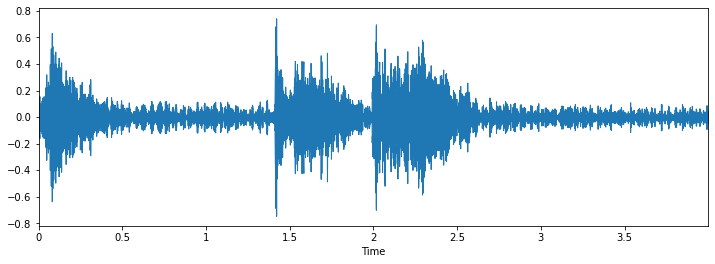

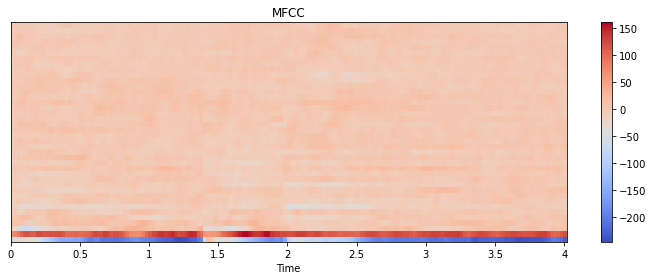

Finished 'test_read_audio' in 2.3969 secs


In [5]:
sonicboom.test_read_audio(filedata.path.iloc[0])


In [6]:
# Get sample rates for all .wave files and add to filedata dataframe

#filedata['Sample Rate'] = Parallel(n_jobs=-1)(delayed(sonicboom.samplerate)(x) for x in filedata['path'])

#filedata.to_csv('./SampleRates.csv')


 ## PARALLEL Generate features and add to dataframe

In [7]:
startTime = time.perf_counter()

#non-parallel version
#filedata['mfccs'] = [sonicboom.mfccsEngineering(x) for x in filedata['path']]

# inputVar = input("0. All, \n \
#     1. MFCCS \n \
#     2. Mel-scaled spectrogram \n \
#     3. Short-time Fourier transform (STFT) \n \
#     4. Chromagram (STFT) \n \
#     5. Spectral contrast (STFT) \n \
#     6. Tonal centroid features (tonnetz) from harmonic components \n")
#     7. Vis's custom FFT feature

mfccs_exec = True
melSpec_exec = True
stft_exec = False #too many elements, array is huge, cannot be flattened
chroma_stft_exec = True 
spectral_contrast_stft_exec = True
tonnetz_exec = True
visFFT_exec = False #huge, cannot be flattened
mfccDelta_exec = False #for neural network only, cannot be normalized
flatten = True
normalize = True

tempDF = pd.DataFrame() 

tempDF = pd.concat(Parallel(n_jobs=-1)(delayed(sonicboom.generateFeatures) \
    (x, mfccs_exec, melSpec_exec, stft_exec, chroma_stft_exec, \
        spectral_contrast_stft_exec, tonnetz_exec, visFFT_exec, mfccDelta_exec, \
        flatten, normalize) for x in filedata['path']))

filedata = filedata.join(tempDF.set_index('path'), on='path')

endTime = time.perf_counter()
runTime = endTime - startTime
print(f'Finished in {runTime:.4f} secs')

filedata.head()


Finished in 119.4185 secs


,path,slice_file_name,fsID,start,end,salience,fold,classID,class,mfccs,melSpec,chroma_stft,spectral_contrast_stft,tonnetz
8678,data\UrbanSound8K\audio\fold9\79089-0-0-6.wav,79089-0-0-6.wav,79089,12.664375,16.664375,2,9,0,air_conditioner,"[0.0, 0.9999999964528422, 0.5784282883423132, ...","[0.28269002855114034, 0.11335797320058538, 0.0...","[0.9999944291871307, 0.7018819993618941, 0.326...","[0.5520161325675481, 0.0, 0.34059093357785564,...","[0.5194640891500628, 0.8044478567534661, 0.0, ..."
7724,data\UrbanSound8K\audio\fold8\54383-0-0-5.wav,54383-0-0-5.wav,54383,2.500000,6.500000,1,8,0,air_conditioner,"[0.0, 0.9999999955118996, 0.3822331980527003, ...","[0.012737550498145947, 0.011544217206358167, 0...","[0.3186848290125621, 0.30914156669132875, 0.03...","[0.39686236530035013, 0.0, 0.5067591154133789,...","[0.9999887482159567, 0.8070120825885805, 0.0, ..."
2493,data\UrbanSound8K\audio\fold2\74507-0-0-8.wav,74507-0-0-8.wav,74507,4.000000,8.000000,1,2,0,air_conditioner,"[0.0, 0.9999999958611567, 0.3914842269683952, ...","[0.22544060104385114, 0.8154566658214984, 0.16...","[0.7850408996754321, 0.8303484199092257, 0.780...","[0.9999999200964598, 0.0, 0.2244116127201951, ...","[0.8869716469647401, 0.7411679436538077, 0.731..."
4959,data\UrbanSound8K\audio\fold5\178686-0-0-16.wav,178686-0-0-16.wav,178686,8.000000,12.000000,2,5,0,air_conditioner,"[0.0, 0.9999999984410389, 0.7257012681358654, ...","[0.9478104450982959, 0.999996802512412, 0.8966...","[0.4700453232815602, 0.29283099133334184, 0.11...","[0.9999998973757407, 0.0, 0.3122020844388404, ...","[0.0, 0.9999735384639149, 0.13455827731543943,..."
5887,data\UrbanSound8K\audio\fold6\204240-0-0-35.wav,204240-0-0-35.wav,204240,17.500000,21.500000,1,6,0,air_conditioner,"[0.0, 0.9999999982737473, 0.5267096221146693, ...","[0.08035943804390117, 0.6097902217151773, 0.99...","[0.46209934981636147, 0.49078480605354946, 0.3...","[0.39143147366157477, 0.0, 0.8066094257453675,...","[0.9493507793842137, 0.8000924560662301, 0.0, ..."


 ## Save the generated features

In [8]:
filedata.to_pickle(SAVEPATH + FILEDESC)


 # Model Generation
 ## Imports

In [9]:
import pandas as pd
import numpy as np
# import tensorflow as tf
# from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
        GradientBoostingClassifier, StackingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import label_binarize
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import cross_validate
from mlxtend.plotting import plot_learning_curves
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split


 ## Read in the features

In [10]:
filedata = pd.read_pickle('./output/intermediate-data/filedata-librosaConventionalFeatures.pkl')


 ## Try traditional ML models
 ### Define and train the models

In [11]:
models = [  
    OneVsRestClassifier(LogisticRegression(random_state=1)),
    OneVsRestClassifier(KNeighborsClassifier(n_neighbors=10)),
    OneVsRestClassifier(DecisionTreeClassifier()),
    OneVsRestClassifier(GaussianNB()),
    OneVsRestClassifier(LinearSVC()),
    OneVsRestClassifier(BaggingClassifier(base_estimator=\
        DecisionTreeClassifier(max_leaf_nodes=2620), n_estimators=100))
]
model_namelist = ['Logistic Regression',
                  'KNeighbors',
                  'Decision Tree',
                  'GaussianNB', 
                  'SVM/Linear SVC',
                  'Bagging-DT'
                  ]
scoring = {'precision': make_scorer(precision_score, average='micro'), 
           'recall': make_scorer(recall_score, average='micro'), 
            'accuracy': make_scorer(accuracy_score), 
           'f1': make_scorer(f1_score, average='micro'),
           'roc_auc': make_scorer(roc_auc_score, average='micro'),
           # 'mcc': make_scorer(matthews_corrcoef) <- cannot support multi-label
          }

cv_result_entries = []
i = 0                  

#this code goes through and separates out each  elements of each feature array into separate columns
# DON'T CHANGE IT
mfccs = pd.DataFrame(filedata['mfccs'].iloc[x] for x in range(len(filedata)))
melSpec = pd.DataFrame(filedata['melSpec'].iloc[x] for x in range(len(filedata)))

#too many elements
#stft = pd.DataFrame(filedata['stft'].iloc[x] for x in range(len(filedata)))
chroma_stft = pd.DataFrame(filedata['chroma_stft'].iloc[x] for x in range(len(filedata)))
spectral_contrast_stft = pd.DataFrame(filedata['spectral_contrast_stft'].iloc[x] for x in range(len(filedata)))
tonnetz = pd.DataFrame(filedata['tonnetz'].iloc[x] for x in range(len(filedata)))

#too many elements, hella big
#visFFT = pd.DataFrame(filedata['visFFT'].iloc[x] for x in range(len(filedata)))

X = pd.concat([mfccs, melSpec, chroma_stft, spectral_contrast_stft, \
    tonnetz], axis=1)

y = label_binarize(
      pd.DataFrame(filedata['classID'].iloc[x] for x in range(len(filedata))),
      classes=[0,1,2,3,4,5,6,7,8,9]
      )

X_train, X_test, y_train, y_test = train_test_split(X, y, \
    test_size=0.20, random_state=0)

# ### Loop cross validation through various models and generate results
for mod in models:
    metrics = cross_validate(
        mod,
        X_train,
        y_train,
        cv=5,
        scoring = scoring,
        return_train_score=False,
        n_jobs=-1
    )
    for key in metrics.keys():
        for fold_index, score in enumerate(metrics[key]):
            cv_result_entries.append((model_namelist[i], fold_index, key, score))
    i += 1
cv_results_df = pd.DataFrame(cv_result_entries)


 ### Misclassification Errors

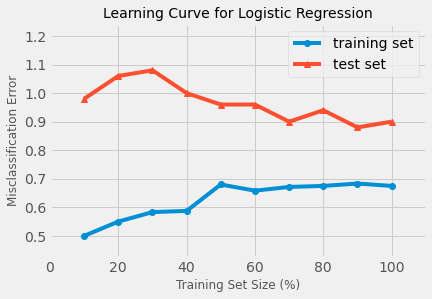

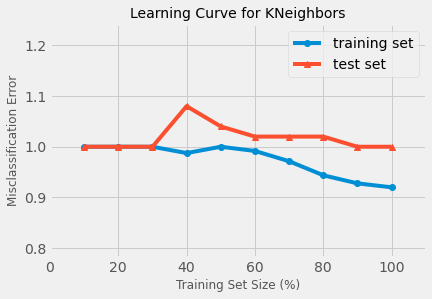

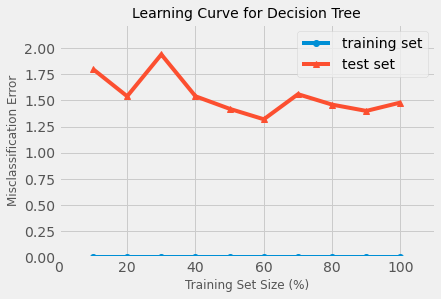

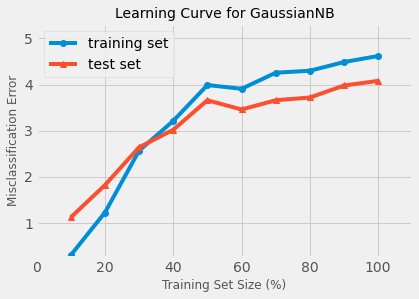

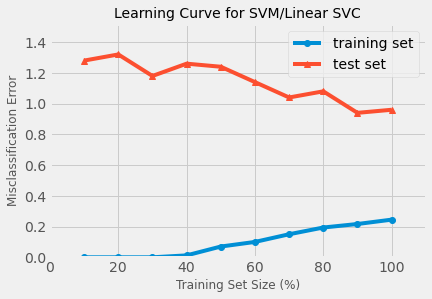

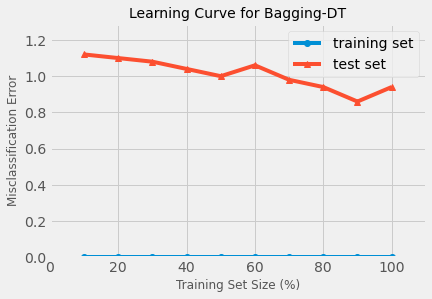

In [12]:
i=0
for model in models:

    plot_learning_curves(X_train, y_train, X_test, y_test, model)
    plt.title('Learning Curve for ' + model_namelist[i], fontsize=14)
    plt.xlabel('Training Set Size (%)', fontsize=12)
    plt.ylabel('Misclassification Error', fontsize=12)
    plt.show()
    i += 1


 ### Get predictions: prep for Confusion Matrix

In [13]:
y_test_pred = []
for model in models:
    y_test_pred.append(model.predict(X_test))



 ### Graph metrics

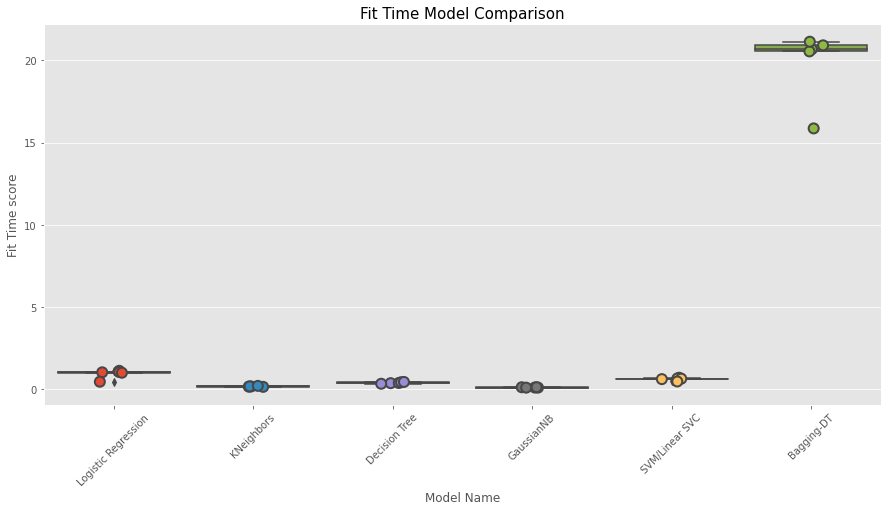

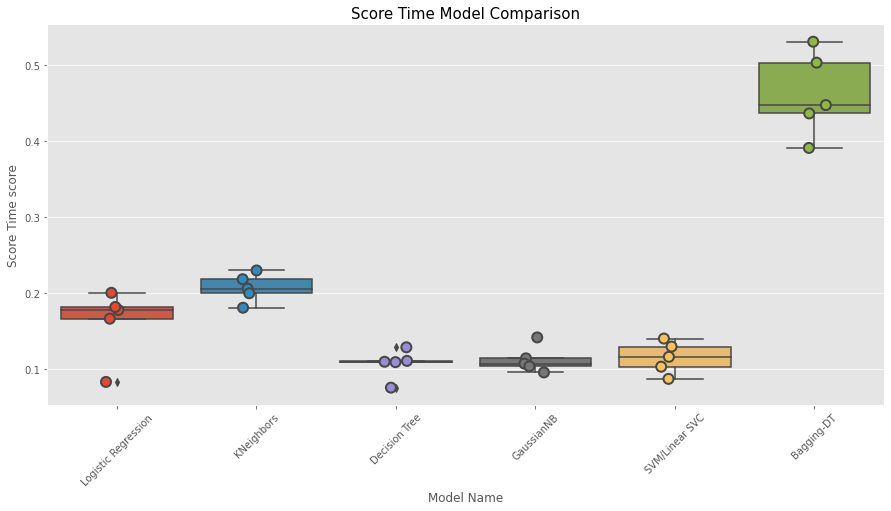

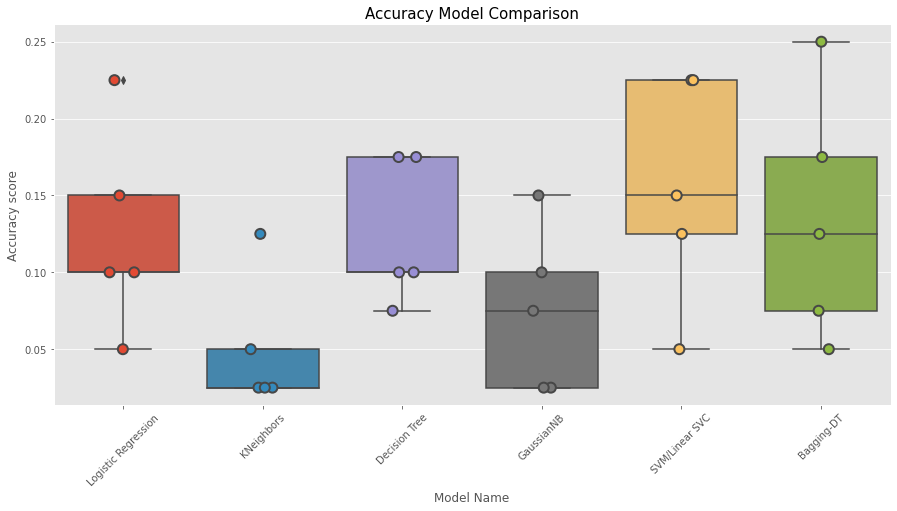

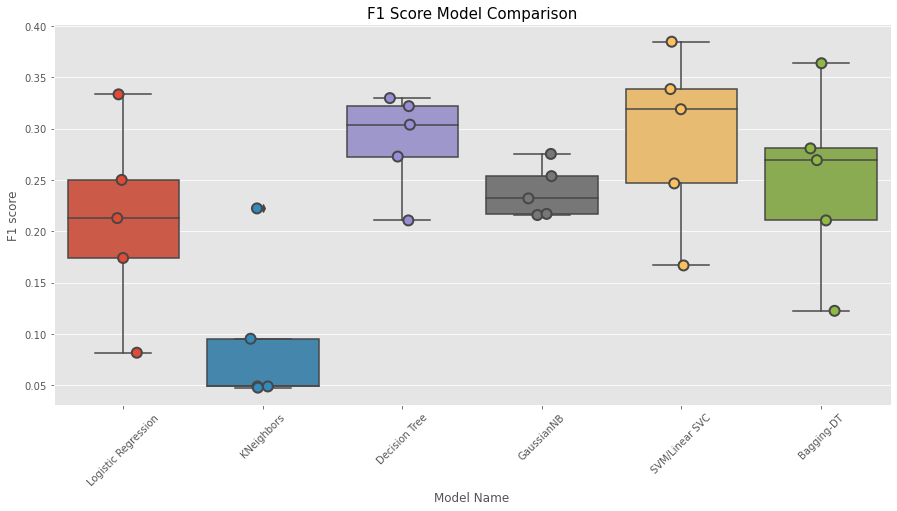

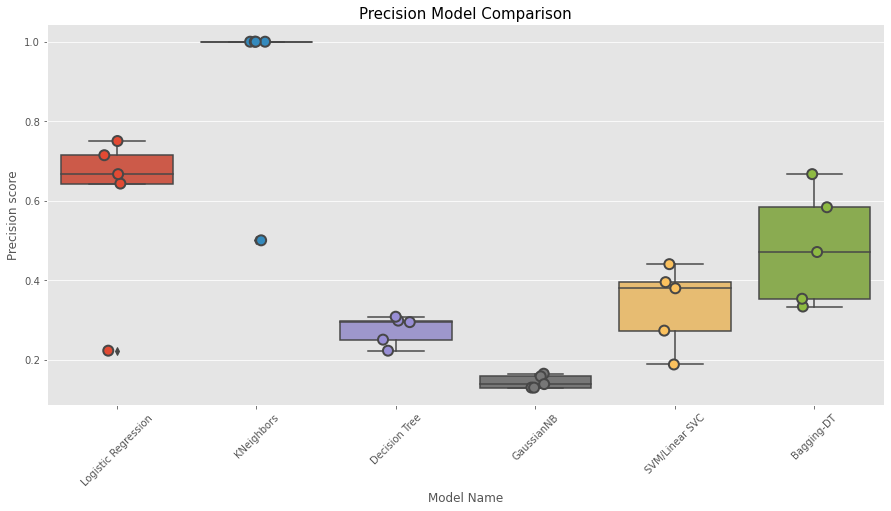

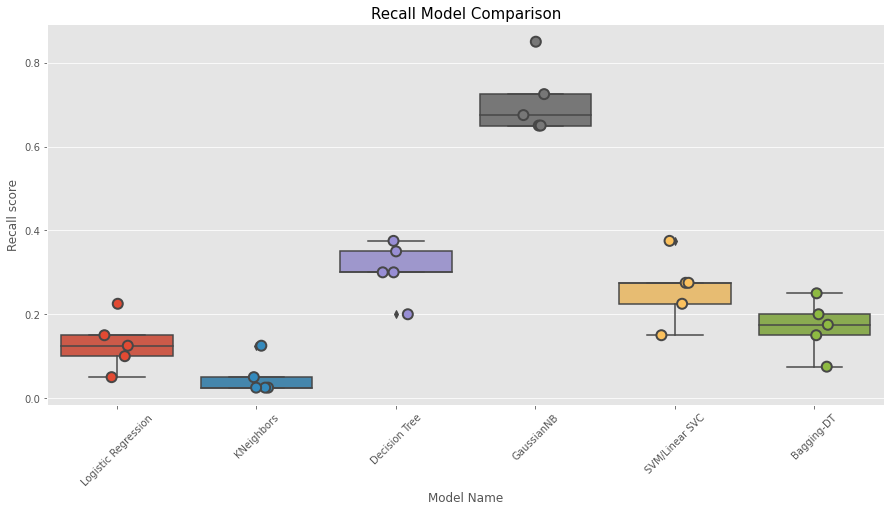

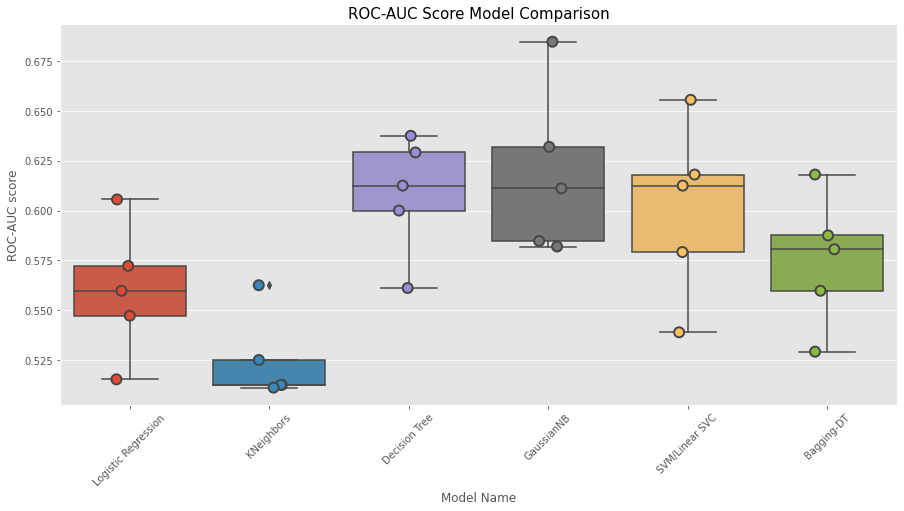

In [14]:
fig_size_tuple = (15,7)
title_fontsize_num = 15
label_fontsize_num = 12

df_cross_validate_results = pd.DataFrame(cv_result_entries, columns =['model_name', 'fold_index', 'metric_key', 'metric_score'])

df_cv_results_fit_time = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'fit_time']
df_cv_results_score_time = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'score_time']
df_cv_results_accuracy = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_accuracy']
df_cv_results_precision = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_precision']
df_cv_results_recall = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_recall']
df_cv_results_f1 = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_f1']
df_cv_results_f2 = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_f2']
df_cv_results_roc_auc = df_cross_validate_results.loc[df_cross_validate_results.metric_key == 'test_roc_auc']


plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_fit_time)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_fit_time, size=10, linewidth=2)
plt.title('Fit Time Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Fit Time score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_score_time)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_score_time, size=10, linewidth=2)
plt.title('Score Time Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Score Time score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_accuracy)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_accuracy, size=10, linewidth=2)
plt.title('Accuracy Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Accuracy score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_f1)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_f1, size=10, linewidth=2)
plt.title('F1 Score Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('F1 score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

# plt.figure(figsize=fig_size_tuple)
# sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_f2)
# sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_f2, size=10, linewidth=2)
# plt.title('F2 Score Model Comparison', fontsize=title_fontsize_num)
# plt.xlabel('Model Name', fontsize=label_fontsize_num)
# plt.ylabel('F2 score', fontsize=label_fontsize_num)
# plt.xticks(rotation=45)
# plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_precision)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_precision, size=10, linewidth=2)
plt.title('Precision Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Precision score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_recall)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_recall, size=10, linewidth=2)
plt.title('Recall Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('Recall score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=fig_size_tuple)
sns.boxplot(x='model_name', y='metric_score', data = df_cv_results_roc_auc)
sns.stripplot(x='model_name', y='metric_score', data = df_cv_results_roc_auc, size=10, linewidth=2)
plt.title('ROC-AUC Score Model Comparison', fontsize=title_fontsize_num)
plt.xlabel('Model Name', fontsize=label_fontsize_num)
plt.ylabel('ROC-AUC score', fontsize=label_fontsize_num)
plt.xticks(rotation=45)
plt.show()


 ### Confusion Matrix

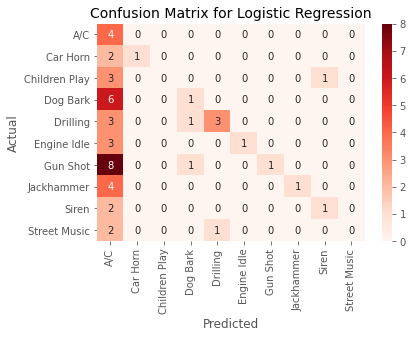

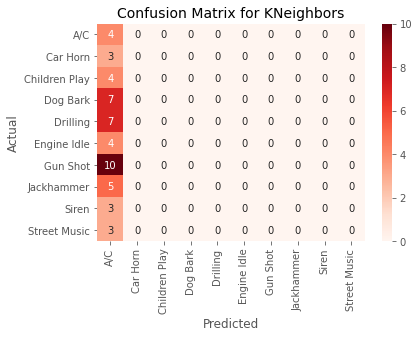

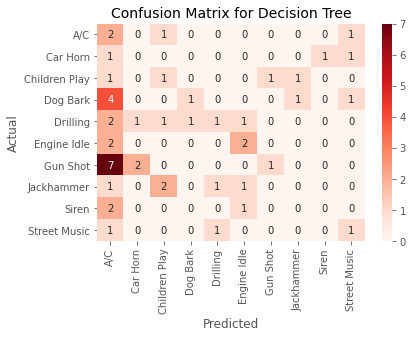

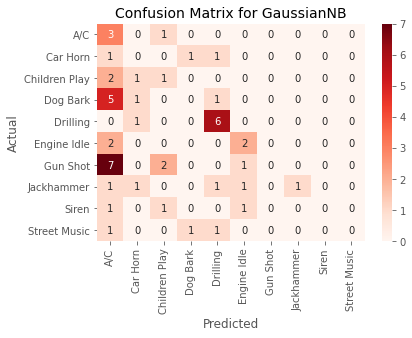

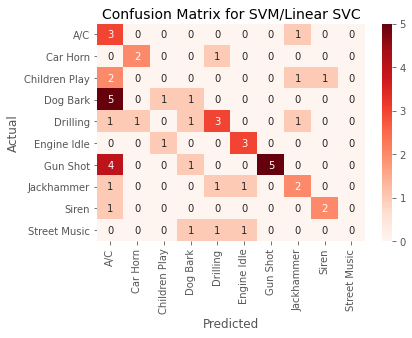

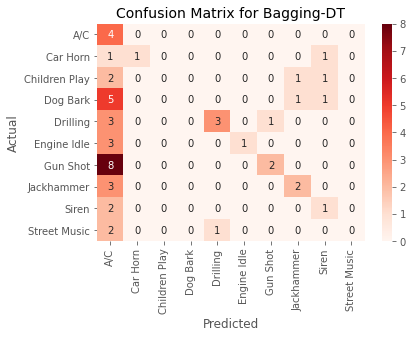

In [15]:
CLASSES = ['A/C', 'Car Horn', 'Children Play', 'Dog Bark',
           'Drilling', 'Engine Idle', 'Gun Shot', 'Jackhammer',
           'Siren', 'Street Music']
i=0
for _ in models:
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_test_pred[i], axis=1))
    cm_df = pd.DataFrame(cm, index = CLASSES, columns = CLASSES)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'
    plt.title('Confusion Matrix for ' + model_namelist[i], fontsize=14)
    sns.heatmap(cm_df, annot=True, fmt='.6g', annot_kws={"size": 10}, cmap='Reds')
    plt.show()
    i += 1


In [16]:

print(mfccs.shape)
print(melSpec.shape)
print(chroma_stft.shape)
print(spectral_contrast_stft.shape)
print(tonnetz.shape)
#print(visFFT.shape)
print(X.shape)


(250, 40)
(250, 128)
(250, 12)
(250, 7)
(250, 6)
(250, 193)


In [17]:

#Sanity check on SVM test results
testResults = pd.DataFrame() 
actual = []
predict = []
for x in range(len(y_test)):
    actual.append(np.argmax(y_test[x])+1)
    predict.append(np.argmax(y_test_pred[4][x])+1)

testResults['actual'] = actual
testResults['predict'] = predict

testResults.head()

testResults.to_csv('testResults')
